# Importing Packages

In [1]:
# General
import os
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pandas as pd
from collections import defaultdict
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics

# Pre-processing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

# Neural Network
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.models import model_from_json

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Mapping Functions

In [2]:

'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''

# Mapping Option 1

from munkres import Munkres
def best_map(L1,L2):
    #L1 should be the groundtruth labels and L2 should be the clustering labels we got
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2 


# Mapping Option 2

import munkres
from sklearn.metrics.cluster import contingency_matrix
def translateLabels(masterList, listToConvert):    
    contMatrix = contingency_matrix(masterList, listToConvert)
    labelMatcher = munkres.Munkres()
    labelTranlater = labelMatcher.compute(contMatrix.max() - contMatrix)

    uniqueLabels1 = list(set(masterList))
    uniqueLabels2 = list(set(listToConvert))

    tranlatorDict = {}
    for thisPair in labelTranlater:
        tranlatorDict[uniqueLabels2[thisPair[1]]] = uniqueLabels1[thisPair[0]]

    return [tranlatorDict[label] for label in listToConvert]



# Mapping Option 3

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped


# Evaluate cluster quality - if you have labels

def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    #pred_labels_mapped = best_map(true_labels,pred_labels) # First variation of Hungarian Method
    #pred_labels_mapped = translateLabels(true_labels,pred_labels) # Second variation with Hungarian Method
    pred_labels_mapped = map_label(true_labels, pred_labels) # basic func
    # all mappings have similar results
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)

    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


# Loading Data

In [3]:
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
text_path = 'data/StackOverflow.txt'# data without labels
label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]

with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row

print("Total: %s short texts" % format(len(data), ","))

Total: 20,000 short texts


# Second Level Pre-processing

In [4]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
y = target # we take the target values

Found 11365 unique tokens.
Minumum length: 1
Average length: 8
Max length: 34


In [5]:
######################################
# Loading word2vec & embedding matrix#
######################################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 4269


In [6]:
###################################################
#Preparing training labels with Average Embeddings#
###################################################
dimen_vect = {}
#binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') similar results as count
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count')
normed_value = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
dimen_vect["ae"] = average_embeddings
print("Shape of average embedding: ", dimen_vect['ae'].shape)
reduction_name = "ae" # average embedding
B = preprocessing.Binarizer().fit_transform(dimen_vect[reduction_name]) 

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

print(B.shape)
print(B[1])

Shape of average embedding:  (20000, 300)
(20000, 300)
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]


# Neural Network Design 

In [7]:
def NN():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    filters = [3,4,5]
    
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    spatial_x = SpatialDropout1D(0.2)(embedded_sequences)
    
    # Layers
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    
    # Dense
    x = Dense(256,activation = 'tanh')(merged) # best performing
    
    # DropOut
    x = Dropout(0.2)(x)
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)
    model.layers[1].trainable=trainable_embedding #embedding layer
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    

    model.summary()
    plot_model(model, to_file='model_plot_no_shapes.png', show_shapes=False, show_layer_names=True) # saving model
    return model

# Grid - Search

In [ ]:
# Grid Search with best model
# Use scikit-learn to grid search the number of neurons
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=NN, epochs=50, batch_size=100,verbose=0)

# define the grid search parameters

#activ = ['relu', 'tanh', 'sigmoid']
#optimizers = ['Nadam','Adam']
droupou = [0.1,0.2,0.3]
#init_mode = ['uniform', 'lecun_uniform']
#filters =[100,120]
#size = [100,120,125]
#filterme = [[3,4,5], [2,3,4]]
#batch_size = [200]
#epochs = [120]
#learn_rate = [0.001, 0.01, 0.02, 0.1]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(droupout = droupou)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs= -1)
grid_result = grid.fit(X, B)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Training

In [9]:
nb_epoch = 10
checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = NN()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      3409800     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 34, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 34, 125)      112625      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_5 (

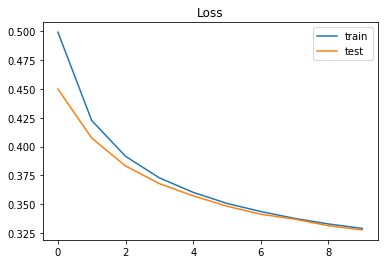

In [10]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

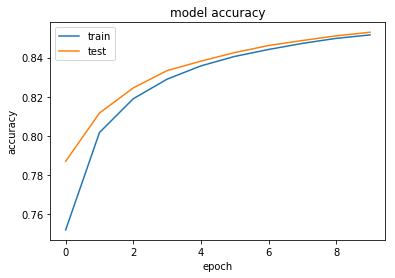

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Preping results
# create model that gives penultimate layer - the layer before the last
input1 = model.layers[0].input
output = model.layers[-2].output
model_penultimate = Model(input1, output)

# Generating Deep-feature representation
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))

# Applying L2 Normalization
V_penul = normalize(H_penul, norm='l2') # norm

Sample shape: (20000, 256)


# Evaluating

In [13]:
true_labels = y # ground truth
n_clusters = len(np.unique(y)) # unique classes - ground truth
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
km.fit(V_penul)
pred = km.labels_
print(pred)
results = cluster_quality(true_labels, pred)
print(results)

Number of classes: 20
[12 12  9 ...  0  0  2]
{'homogeneity': 0.453, 'completeness': 0.479, 'vmeasure': 0.466, 'nmi': 0.466, 'rand': 0.272, 'accuracy': 0.503}


/Users/Dimitar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


# Running clusterS (100 runs and storing results)

In [ ]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

# clustering loop
true_labels = y
n_clusters = len(np.unique(y))
kMeans = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
df = pd.DataFrame()
for i in range(100):
    kkMeansm.fit(V)
    pred = kMeans.labels_
    pred1 = kMeans.cluster_centers_

    a = cluster_quality(true_labels, pred)
    df = df.append([a],ignore_index=True)
    print('Run {} was completed!'.format(i))   

In [ ]:
# using binary - new like count

import statistics 
df_binary = df
df_binary['Normal_ACC'] = df_binary['accuracy'].map(lambda a: a * 100)
df_binary['Normal_NMI'] = df_binary['nmi'].map(lambda a: a * 100)

max_acc = df_binary['Normal_ACC'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))

min_acc = df_binary['Normal_ACC'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))

average_acc = df_binary['Normal_ACC'].mean() # 0.514
print('Average Accuracy is: {}'.format(average_acc))

average_nmi = df_binary['Normal_NMI'].mean() # 0.514
print('Average NMI is: {}'.format(average_nmi))

standard_dev_acc = statistics.stdev(df_binary['Normal_ACC'])
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))

standard_dev_nmi = statistics.stdev(df_binary['Normal_NMI'])
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))

df_binary.to_csv('100cluster_BinaryBased.csv')
df_binary.head(5)

# Save/Load Model 

In [ ]:
from keras.models import model_from_json
# Saving Model and weiths
# serialize model to JSON
'''
model_json = model.to_json()
with open("model_55%.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_55%.h5")
print("Saved model to disk")
'''

# load json and create model
json_file = open('model_55%_StackData.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_55%_StackData.h5")
print("Loaded model from disk")

# Evaluate

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

